# Introdução aos Ataques DDoS no Dataset CICDDoS2019

O dataset contém múltiplos cenários de ataques, registrados em arquivos CSV, com detalhes sobre tráfego malicioso e legítimo. Abaixo, são listados os períodos de tempo (em horas e minutos) em que os ataques ocorreram, organizados por dia e tipo de ataque.


## Ataques coloetados no dia (01/12)

```csv
data_path, length, columns, hour
DrDos_NTP.csv, 1217007, 88, 10:35 - 10:45
DrDos_DNS.csv, 5074413, 88, 10:52 - 11:05
DrDos_LDAP.csv, 2181542, 88, 11:22 - 11:32
DrDos_MSSQL.csv, 4524498, 88, 11:36 - 11:45
DrDos_NetBIOS.csv, 4094986, 88, 11:50 - 12:00
DrDos_SNMP.csv, 5161377, 88, 12:12 - 12:23
DrDos_SSDP.csv, 2611374, 88, 12:27 - 12:37
DrDos_UDP.csv, 3136802, 88, 12:45 - 13:09
UDPLag.csv, 370605, 88, 13:11 - 13:15
Syn.csv, 1582681, 88, 13:29 - 13:34
TFTP.csv, 20107827, 88, 13:35 - 17:15
```

## Ataques coloetados no dia (03/11)

```csv
data_path, length, columns, hour
NetBIOS.csv, 3455899, 88, 10:00 - 10:09
LDAP.csv, 2113234, 88, 10:21 - 10:30
MSSQL.csv, 5775786, 88, 10:33 - 10:42
UDP.csv, 3782206, 88,  10:53 - 11:03
UDPLag.csv, 725165, 88, 11:14 - 11:24
Syn.csv, 4320541, 88, 11:28 - 17:35
```

Portmap.csv não tem período de ataque 

# Pré-Processamento UEL - Gerando dados para treinamento

In [ ]:
# selected_columns = [
#     ' Source IP',
#     ' Source Port',
#     ' Destination IP',
#     ' Destination Port',
#     ' Timestamp',
#     ' Flow Duration',
#     ' Total Fwd Packets',
#     ' Total Backward Packets',
#     'Total Length of Fwd Packets',
#     ' Total Length of Bwd Packets',
#     'Flow Bytes/s',
#     ' Flow Packets/s',
#     'Fwd Packets/s',
#     ' Bwd Packets/s',
# ]

import pandas as pd
from itertools import cycle
import random

# 1. Carregar os arquivos
teste_ataque = pd.read_csv('data/cic_puro/teste_ataque_ordenado.csv', sep=';')
teste_normal = pd.read_csv('data/cic_puro/teste_sem_ataque_ordenado.csv', sep=';')
treino_ataque = pd.read_csv('data/cic_puro/treino_ataque_ordenado.csv', sep=';')
treino_normal = pd.read_csv('data/cic_puro/treino_sem_ataque_ordenado.csv', sep=';')


# 2. Concatenar para treino e teste
teste_full = pd.concat([teste_normal, teste_ataque], ignore_index=True)
treino_full = pd.concat([treino_normal, treino_ataque], ignore_index=True)

# 3. Separar normais e ataques
def prepare_data(df, max_per_attack=1000, max_normal=5000):
    normal = df[df['label'] == 0].sample(frac=1).reset_index(drop=True)  # embaralhar normais
    attacks = df[df['label'] == 1].reset_index(drop=True)

    # Agora limitar por tipo de ataque
    attack_types = {}
    for name, group in attacks.groupby('attack_name'):
        attack_types[name] = group.sample(n=min(len(group), max_per_attack)).reset_index(drop=True)

    # Limitar normais
    if max_normal is not None:
        normal = normal.sample(n=min(len(normal), max_normal)).reset_index(drop=True)

    return normal, attack_types

train_normal, train_attacks = prepare_data(treino_full, max_per_attack=1000, max_normal=10000)
test_normal, test_attacks = prepare_data(teste_full, max_per_attack=500, max_normal=5000)

# 4. Função para criar sequências aleatórias
def create_random_sequences(normal_df, attack_dict, min_seq=30, max_seq=150):
    final_rows = []
    
    normal_iter = normal_df.iterrows()
    attack_iters = {k: v.iterrows() for k, v in attack_dict.items()}
    attack_cycle = cycle(list(attack_iters.keys()))
    
    normal_remaining = True
    attack_remaining = True

    while normal_remaining or attack_remaining:
        choice = random.choice(['normal', 'attack'])  # Aleatoriamente decidir normal ou ataque primeiro
        
        if choice == 'normal' and normal_remaining:
            seq_len = random.randint(min_seq, max_seq)
            for _ in range(seq_len):
                try:
                    idx, row = next(normal_iter)
                    final_rows.append(row)
                except StopIteration:
                    normal_remaining = False
                    break
        
        elif choice == 'attack' and attack_remaining:
            attack_type = next(attack_cycle)
            seq_len = random.randint(min_seq, max_seq)
            for _ in range(seq_len):
                try:
                    idx, row = next(attack_iters[attack_type])
                    final_rows.append(row)
                except StopIteration:
                    # Se esgotar ataques desse tipo, remover do ciclo
                    del attack_iters[attack_type]
                    if attack_iters:
                        attack_cycle = cycle(list(attack_iters.keys()))
                    else:
                        attack_remaining = False
                    break
        else:
            # Se o tipo escolhido acabou, tenta o outro
            continue

    return pd.DataFrame(final_rows)

# 5. Criar datasets
train_final = create_random_sequences(train_normal, train_attacks, min_seq=30, max_seq=120)
test_final = create_random_sequences(test_normal, test_attacks, min_seq=30, max_seq=120)

# 6. Salvar
train_final.to_csv('treino_final_estratificado_random.csv', sep=';', index=False)
test_final.to_csv('teste_final_estratificado_random.csv', sep=';', index=False)

print('Arquivos treino_final_estratificado_random.csv e teste_final_estratificado_random.csv gerados com sequências aleatórias!')



Arquivos treino_final_estratificado_random.csv e teste_final_estratificado_random.csv gerados com sequências aleatórias!


In [ ]:
# Contar a quantidade de cada valor na coluna 'attack_name'
attack_counts_train = train_final['attack_name'].value_counts()
attack_counts_test = test_final['attack_name'].value_counts()

# Exibir os resultados
print('Tamanho:', len(train_final), 'Treino:', attack_counts_train)
print('Total de linhas no conjunto de treino:', len(train_final))

print('Tamanho:', len(test_final), 'Teste:', attack_counts_test)
print('Total de linhas no conjunto de teste:', len(test_final))

Tamanho: 13 Treino: attack_name
normal           8074
DrDoS_DNS        1000
DrDoS_NTP        1000
DrDoS_SNMP       1000
DrDoS_UDP        1000
TFTP             1000
UDP-lag           885
DrDoS_SSDP        822
DrDoS_NetBIOS     726
DrDoS_MSSQL       687
DrDoS_LDAP        592
Syn               237
WebDDoS           125
Name: count, dtype: int64
Tamanho: 8 Teste: attack_name
normal     5000
LDAP        500
MSSQL       500
NetBIOS     500
Syn         500
UDP         500
UDPLag      470
Portmap     449
Name: count, dtype: int64


# Testes CIC

In [52]:
import pandas as pd
import os

def contar_rotulos_csv(lista_arquivos, coluna_label=' Label'):
    for arquivo in lista_arquivos:
        try:
            print(f"\n📄 Analisando: {arquivo}")
            df = pd.read_csv(arquivo, usecols=[coluna_label], low_memory=False)
            
            total_linhas = len(df)
            contagem_rotulos = df[coluna_label].value_counts(dropna=False)
            soma_rotulos = contagem_rotulos.sum()

            print(f"  ➤ Total de linhas: {total_linhas}")
            print("  ➤ Contagem de rótulos:")
            for rotulo, qtd in contagem_rotulos.items():
                print(f"     - {rotulo}: {qtd}")

            if soma_rotulos == total_linhas:
                print("  ✅ A soma de todos os rótulos é igual ao total de linhas.")
            else:
                print("  ❌ A soma de todos os rótulos NÃO é igual ao total de linhas.")

        except Exception as e:
            print(f"❌ Erro ao ler {arquivo}: {e}")


In [ ]:
csv_files1 = [
    'data/03-11/attacks_labeled/LDAP_labeled.csv',
    'data/03-11/attacks_labeled/Mssql_labeled.csv',
    'data/03-11/attacks_labeled/NetBIOS_labeled.csv',
    'data/03-11/attacks_labeled/Syn_labeled.csv',
    'data/03-11/attacks_labeled/UDP_labeled.csv',
    'data/03-11/attacks_labeled/UDPLag_labeled.csv'
]

csv_files2 = [
    'data/01-12/attacks_labeled/DrDos_DNS_labeled.csv',
    'data/01-12/attacks_labeled/DrDos_LDAP_labeled.csv',
    'data/01-12/attacks_labeled/DrDos_MSSQL_labeled.csv',
    'data/01-12/attacks_labeled/DrDos_NetBIOS_labeled.csv',
    'data/01-12/attacks_labeled/DrDos_NTP_labeled.csv',
    'data/01-12/attacks_labeled/DrDos_SNMP_labeled.csv',
    'data/01-12/attacks_labeled/DrDos_SSDP_labeled.csv',
    'data/01-12/attacks_labeled/DrDos_UDP_labeled.csv',
    'data/01-12/attacks_labeled/Syn_labeled.csv',
    'data/01-12/attacks_labeled/UDPLag_labeled.csv'   
]

csv_files3 = [
    'data/Full_dataset/03-11/LDAP.csv',
    'data/Full_dataset/03-11/Mssql.csv',
    'data/Full_dataset/03-11/NetBIOS.csv',
    'data/Full_dataset/03-11/Syn.csv',
    'data/Full_dataset/03-11/UDP.csv',
    'data/Full_dataset/03-11/UDPLag.csv'
]

csv_files4 = [
    'data/Full_dataset/01-12/DrDos_DNS.csv',
    'data/Full_dataset/01-12/DrDos_LDAP.csv',
    'data/Full_dataset/01-12/DrDos_MSSQL.csv',
    'data/Full_dataset/01-12/DrDos_NetBIOS.csv',
    'data/Full_dataset/01-12/DrDos_NTP.csv',
    'data/Full_dataset/01-12/DrDos_SNMP.csv',
    'data/Full_dataset/01-12/DrDos_SSDP.csv',
    'data/Full_dataset/01-12/DrDos_UDP.csv',
    'data/Full_dataset/01-12/Syn.csv',
    'data/Full_dataset/01-12/UDPLag.csv'   
]

csv_files5 = [
    'data/01-12/attacks_labeled/DrDos_DNS_processado.csv',
    'data/01-12/attacks_labeled/DrDos_LDAP_processado.csv',
    'data/01-12/attacks_labeled/DrDos_MSSQL_processado.csv',
    'data/01-12/attacks_labeled/DrDos_NetBIOS_processado.csv',
    'data/01-12/attacks_labeled/DrDos_NTP_processado.csv',
    'data/01-12/attacks_labeled/DrDos_SNMP_processado.csv',
    'data/01-12/attacks_labeled/DrDos_SSDP_processado.csv',
    'data/01-12/attacks_labeled/DrDos_UDP_processado.csv',
    'data/01-12/attacks_labeled/Syn_processado.csv',
    'data/01-12/attacks_labeled/UDPLag_processado.csv'    
]

csv_files6 = [
    'data/03-11/attacks_labeled/LDAP_processado.csv',
    'data/03-11/attacks_labeled/Mssql_processado.csv',
    'data/03-11/attacks_labeled/NetBIOS_processado.csv',
    'data/03-11/attacks_labeled/Syn_processado.csv',
    'data/03-11/attacks_labeled/UDP_processado.csv',
    'data/03-11/attacks_labeled/UDPLag_processado.csv'
]
    
contar_rotulos_csv(csv_files5, coluna_label='definicao_ataque')
# contar_rotulos_csv(csv_files5, coluna_label=' Label')




📄 Analisando: data/01-12/attacks_labeled/DrDos_DNS_processado.csv
  ➤ Total de linhas: 2152
  ➤ Contagem de rótulos:
     - 0: 1126
     - 1: 1026
  ✅ A soma de todos os rótulos é igual ao total de linhas.

📄 Analisando: data/01-12/attacks_labeled/DrDos_LDAP_processado.csv
  ➤ Total de linhas: 919
  ➤ Contagem de rótulos:
     - 0: 652
     - 1: 267
  ✅ A soma de todos os rótulos é igual ao total de linhas.

📄 Analisando: data/01-12/attacks_labeled/DrDos_MSSQL_processado.csv
  ➤ Total de linhas: 985
  ➤ Contagem de rótulos:
     - 0: 538
     - 1: 447
  ✅ A soma de todos os rótulos é igual ao total de linhas.

📄 Analisando: data/01-12/attacks_labeled/DrDos_NetBIOS_processado.csv
  ➤ Total de linhas: 961
  ➤ Contagem de rótulos:
     - 1: 505
     - 0: 456
  ✅ A soma de todos os rótulos é igual ao total de linhas.

📄 Analisando: data/01-12/attacks_labeled/DrDos_NTP_processado.csv
  ➤ Total de linhas: 4281
  ➤ Contagem de rótulos:
     - 0: 2626
     - 1: 1655
  ✅ A soma de todos os rót

# Correção do CICDDoS - Calculo da entropia e concatenação de tempo em 1 segundo

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from collections import Counter
import os
from glob import glob

# Função para calcular entropia
def calcular_entropia(valores):
    contagem = Counter(valores)
    probs = [v / sum(contagem.values()) for v in contagem.values()]
    return entropy(probs, base=2)

# Função para processar dataset individual
def processar_dataset(caminho_csv, linhas=None, caminho_saida="dataset_processado.csv"):
    try:
        print(f"\n📥 Lendo o arquivo: {caminho_csv}")
        df = pd.read_csv(caminho_csv, nrows=linhas, low_memory=False)

        # Calcular entropias
        df['src_ip_entropy'] = calcular_entropia(df[' Source IP']) if ' Source IP' in df.columns else 0
        df['dst_ip_entropy'] = calcular_entropia(df[' Destination IP']) if ' Destination IP' in df.columns else 0
        df['src_port_entropy'] = calcular_entropia(df[' Source Port']) if ' Source Port' in df.columns else 0
        df['dst_port_entropy'] = calcular_entropia(df[' Destination Port']) if ' Destination Port' in df.columns else 0

        # Arredondar timestamp
        if ' Timestamp' in df.columns:
            df['segundo'] = pd.to_datetime(df[' Timestamp']).dt.floor('ms')
        else:
            print("❌ Coluna ' Timestamp' não encontrada.")
            return

        # Converter label
        if ' Label' in df.columns:
            df['attack_label'] = df[' Label'].apply(lambda x: 0 if str(x).strip().upper() == 'BENIGN' else 1)

        # Agrupar por segundo e calcular médias
        colunas_numericas = df.select_dtypes(include=[np.number]).columns
        df_agrupado = df.groupby('segundo')[colunas_numericas].mean().reset_index()

        # 1. Média e Desvio Padrão
        mean = df_agrupado['attack_label'].mean()
        std_dev = df_agrupado['attack_label'].std()
        print(f"\n📊 Média: {mean}, Desvio Padrão: {std_dev}")

        # 2. Coeficiente de Variação (CV)
        cv = std_dev / mean if mean != 0 else 0
        print(f"Coeficiente de Variação (CV): {cv}")

        # 3. Percentil 75 para determinar o limiar de ataque
        percentil_75 = df_agrupado['attack_label'].quantile(0.75)
        print(f"Percentil 75 (Limiar de ataque): {percentil_75}")

        # Definir o limiar de ataque como sendo o percentil 75
        limiar_ataque = percentil_75
        df_agrupado['definicao_ataque'] = df_agrupado['attack_label'].apply(lambda x: 1 if x >= limiar_ataque else 0)

        # Exibir resumo de ataques e benignos
        benignos = df_agrupado[df_agrupado['definicao_ataque'] == 0].shape[0]
        ataques = df_agrupado[df_agrupado['definicao_ataque'] == 1].shape[0]
        print(f"\n👥 Benignos: {benignos}, Ataques: {ataques}")

        # Corrigir attack_label
        if 'attack_label' in df_agrupado.columns:
            df_agrupado['attack_label'] = df_agrupado['attack_label'].apply(lambda x: 1 if x > 0.6 else 0)

        # Adicionar nome do ataque
        if ' Label' in df.columns:
            df_nome_ataque = df[['segundo', ' Label']].drop_duplicates()
            df_agrupado = df_agrupado.merge(df_nome_ataque, on='segundo', how='left')
            df_agrupado.rename(columns={' Label': 'attack_name'}, inplace=True)

        # Remover colunas desnecessárias
        colunas_remover = ['segundo', 'Unnamed: 0', 'Flow ID', 'Source IP', 'Destination IP', ' Timestamp',
                           ' Source Port', ' Destination Port', ' Protocol', 'attack_name']
        df_agrupado.drop(columns=[col for col in colunas_remover if col in df_agrupado.columns], errors='ignore', inplace=True)

        # Salvar
        df_agrupado.to_csv(caminho_saida, index=False)
        print(f"✅ Salvo: {caminho_saida}")
        return df_agrupado

    except Exception as e:
        print(f"❌ Erro ao processar o arquivo {caminho_csv}: {e}")

# Função para processar múltiplos CSVs
def processar_varios_csvs(pasta_entrada, pasta_saida, linhas=None):
    arquivos_csv = glob(os.path.join(pasta_entrada, "*.csv"))
    os.makedirs(pasta_saida, exist_ok=True)

    for caminho_csv in arquivos_csv:
        nome_arquivo = os.path.basename(caminho_csv).replace(".csv", "_processado.csv")
        caminho_saida = os.path.join(pasta_saida, nome_arquivo)
        processar_dataset(caminho_csv, linhas=linhas, caminho_saida=caminho_saida)


In [13]:
# Processar no máximo 10000 linhas de cada arquivo
# processar_varios_csvs("data/01-12/attacks", "data/01-12/attacks_labeled", linhas=None)
processar_varios_csvs("data/03-11/attacks", "data/03-11/attacks_labeled", linhas=None)


📥 Lendo o arquivo: data/03-11/attacks\LDAP.csv

📊 Média: 0.9958969769783095, Desvio Padrão: 0.05889595350810446
Coeficiente de Variação (CV): 0.05913860054762191
Percentil 75 (Limiar de ataque): 1.0

👥 Benignos: 3348, Ataques: 494342
✅ Salvo: data/03-11/attacks_labeled\LDAP_processado.csv

📥 Lendo o arquivo: data/03-11/attacks\MSSQL.csv

📊 Média: 0.9987180099380428, Desvio Padrão: 0.03165019544786269
Coeficiente de Variação (CV): 0.031690822767706135
Percentil 75 (Limiar de ataque): 1.0

👥 Benignos: 1794, Ataques: 478991
✅ Salvo: data/03-11/attacks_labeled\MSSQL_processado.csv

📥 Lendo o arquivo: data/03-11/attacks\NetBIOS.csv

📊 Média: 0.9996527972804911, Desvio Padrão: 0.00905698055109421
Coeficiente de Variação (CV): 0.009060126251567848
Percentil 75 (Limiar de ataque): 1.0

👥 Benignos: 875, Ataques: 428513
✅ Salvo: data/03-11/attacks_labeled\NetBIOS_processado.csv

📥 Lendo o arquivo: data/03-11/attacks\Syn.csv

📊 Média: 0.9552459438792898, Desvio Padrão: 0.2063760175667755
Coefici

In [16]:
import pandas as pd
import os
from glob import glob

def contar_labels(pasta_entrada):
    arquivos_csv = glob(os.path.join(pasta_entrada, "*.csv"))
    
    if not arquivos_csv:
        print("❌ Nenhum arquivo CSV encontrado na pasta especificada.")
        return

    print(f"📂 Analisando {len(arquivos_csv)} arquivos na pasta: {pasta_entrada}\n")
    
    for arquivo in arquivos_csv:
        try:
            df = pd.read_csv(arquivo, low_memory=False)
            
            if 'attack_label' not in df.columns:
                print(f"⚠️  Arquivo {os.path.basename(arquivo)} não possui a coluna 'attack_label'. Ignorado.")
                continue
            
            benignos = (df['attack_label'] == 0).sum()
            maliciosos = (df['attack_label'] == 1).sum()

            print(f"📄 {os.path.basename(arquivo)}")
            print(f"   ✅ Benignos:   {benignos}")
            print(f"   ❌ Maliciosos: {maliciosos}\n")
        
        except Exception as e:
            print(f"❌ Erro ao processar {arquivo}: {e}")

# Exemplo de uso
pasta_csv = "data/03-11/attacks_labeled"  # Altere aqui
contar_labels(pasta_csv)


📂 Analisando 12 arquivos na pasta: data/03-11/attacks_labeled

📄 01_NetBIOS_processado.csv
   ✅ Benignos:   0
   ❌ Maliciosos: 607

📄 02_LDAP_processado.csv
   ✅ Benignos:   317
   ❌ Maliciosos: 958

📄 03_MSSQL_processado.csv
   ✅ Benignos:   116
   ❌ Maliciosos: 1007

📄 04_UDP_processado.csv
   ✅ Benignos:   152
   ❌ Maliciosos: 1372

📄 05_UDPLag_processado.csv
   ✅ Benignos:   574
   ❌ Maliciosos: 923

📄 06_Syn_processado.csv
   ✅ Benignos:   4369
   ❌ Maliciosos: 3453

📄 LDAP_processado.csv
   ✅ Benignos:   2063
   ❌ Maliciosos: 497374

📄 MSSQL_processado.csv
   ✅ Benignos:   510
   ❌ Maliciosos: 481617

📄 NetBIOS_processado.csv
   ✅ Benignos:   93
   ❌ Maliciosos: 430169

📄 Syn_processado.csv
   ✅ Benignos:   19476
   ❌ Maliciosos: 417068

📄 UDPLag_processado.csv
   ✅ Benignos:   2575
   ❌ Maliciosos: 105449

📄 UDP_processado.csv
   ✅ Benignos:   1214
   ❌ Maliciosos: 488492



In [15]:
import pandas as pd
import os
from glob import glob

def contar_labels(pasta_entrada):
    arquivos_csv = glob(os.path.join(pasta_entrada, "*.csv"))
    
    if not arquivos_csv:
        print("❌ Nenhum arquivo CSV encontrado na pasta especificada.")
        return

    print(f"📂 Analisando {len(arquivos_csv)} arquivos na pasta: {pasta_entrada}\n")
    
    for arquivo in arquivos_csv:
        try:
            df = pd.read_csv(arquivo, low_memory=False)
            
            if 'definicao_ataque' not in df.columns:
                print(f"⚠️  Arquivo {os.path.basename(arquivo)} não possui a coluna 'definicao_ataque'. Ignorado.")
                continue
            
            benignos = (df['definicao_ataque'] == 0).sum()
            maliciosos = (df['definicao_ataque'] == 1).sum()

            print(f"📄 {os.path.basename(arquivo)}")
            print(f"   ✅ Benignos:   {benignos}")
            print(f"   ❌ Maliciosos: {maliciosos}\n")
        
        except Exception as e:
            print(f"❌ Erro ao processar {arquivo}: {e}")

# Exemplo de uso
pasta_csv = "data/03-11/attacks_labeled"  # Altere aqui
contar_labels(pasta_csv)


📂 Analisando 12 arquivos na pasta: data/03-11/attacks_labeled

📄 01_NetBIOS_processado.csv
   ✅ Benignos:   348
   ❌ Maliciosos: 259

📄 02_LDAP_processado.csv
   ✅ Benignos:   1013
   ❌ Maliciosos: 262

📄 03_MSSQL_processado.csv
   ✅ Benignos:   858
   ❌ Maliciosos: 265

📄 04_UDP_processado.csv
   ✅ Benignos:   978
   ❌ Maliciosos: 546

📄 05_UDPLag_processado.csv
   ✅ Benignos:   912
   ❌ Maliciosos: 585

📄 06_Syn_processado.csv
   ✅ Benignos:   4851
   ❌ Maliciosos: 2971

📄 LDAP_processado.csv
   ✅ Benignos:   5095
   ❌ Maliciosos: 494342

📄 MSSQL_processado.csv
   ✅ Benignos:   3136
   ❌ Maliciosos: 478991

📄 NetBIOS_processado.csv
   ✅ Benignos:   1749
   ❌ Maliciosos: 428513

📄 Syn_processado.csv
   ✅ Benignos:   20600
   ❌ Maliciosos: 415944

📄 UDPLag_processado.csv
   ✅ Benignos:   2847
   ❌ Maliciosos: 105177

📄 UDP_processado.csv
   ✅ Benignos:   3180
   ❌ Maliciosos: 486526



# Estratificação

In [43]:
import pandas as pd

def estratificar_csv_treino(arquivo_csv, coluna_ataque='definicao_ataque', arquivo_saida='estratificado.csv'):
    # Carregar o arquivo CSV
    df = pd.read_csv(arquivo_csv)
    
    # Separar os dados em benignos (0) e ataques (1)
    benignos = df[df[coluna_ataque] == 0]
    ataques = df[df[coluna_ataque] == 1]
    
    # Determinar o número de amostras a serem usadas para cada classe
    n_amostras = min(len(benignos), len(ataques))
    
    # Amostrar os dados para balancear as classes
    benignos_amostrados = benignos.sample(n=n_amostras, random_state=42)
    ataques_amostrados = ataques.sample(n=n_amostras, random_state=42)
    
    # Dividir os benignos em duas partes iguais
    benignos_metade = len(benignos_amostrados) // 2
    benignos_parte1 = benignos_amostrados.iloc[:benignos_metade]
    benignos_parte2 = benignos_amostrados.iloc[benignos_metade:]
    
    # Concatenar os dados na ordem: NORMAL/2 - ATAQUE - NORMAL/2
    df_estratificado = pd.concat([benignos_parte1, ataques_amostrados, benignos_parte2], ignore_index=True)
    
    # Salvar o arquivo estratificado
    df_estratificado.to_csv(arquivo_saida, index=False)
    print(f"Arquivo estratificado salvo como: {arquivo_saida}")

def estratificar_csv_teste(arquivo_csv, coluna_ataque='definicao_ataque', arquivo_saida='teste_50porcento.csv'):
    # Carregar o arquivo CSV
    df = pd.read_csv(arquivo_csv)

    # Separar os dados
    benignos = df[df[coluna_ataque] == 0].reset_index(drop=True)
    ataques = df[df[coluna_ataque] == 1].reset_index(drop=True)

    # Garantir balanceamento: usar 50% da menor classe
    limite = min(len(benignos), len(ataques))
    n_amostras = limite // 2  # 50% dos dados da menor classe

    # Amostrar dados equilibrados
    benignos_amostrados = benignos.sample(n=n_amostras, random_state=42).reset_index(drop=True)
    ataques_amostrados = ataques.sample(n=n_amostras, random_state=42).reset_index(drop=True)

    # Dividir os benignos ao meio
    metade_benignos = n_amostras // 2
    benignos_parte1 = benignos_amostrados.iloc[:metade_benignos]
    benignos_parte2 = benignos_amostrados.iloc[metade_benignos:]

    # Concatenar: NORMAL/2 → ATAQUE → NORMAL/2
    df_teste = pd.concat([benignos_parte1, ataques_amostrados, benignos_parte2], ignore_index=True)

    # Salvar o arquivo final
    df_teste.to_csv(arquivo_saida, index=False)
    print(f"Arquivo de teste balanceado salvo como: {arquivo_saida}")
    


In [51]:
# Exemplo de uso
# estratificar_csv_treino('data/03-11/attacks_labeled/LDAP_processado.csv ', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado/LDAP_estratificado.csv')
# estratificar_csv_treino('data/03-11/attacks_labeled/MSSQL_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado/MSSQL_estratificado.csv')
# estratificar_csv_treino('data/03-11/attacks_labeled/NetBIOS_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado/NetBIOS_estratificado.csv')
# estratificar_csv_treino('data/03-11/attacks_labeled/Syn_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado/Syn_estratificado.csv')
# estratificar_csv_treino('data/03-11/attacks_labeled/UDP_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado/UDP_estratificado.csv')
# estratificar_csv_treino('data/03-11/attacks_labeled/UDPLag_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado/UDPLag_estratificado.csv')


# estratificar_csv_teste('data/03-11/attacks_labeled/LDAP_processado.csv ', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado_teste/LDAP_estratificado.csv')
# estratificar_csv_teste('data/03-11/attacks_labeled/MSSQL_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado_teste/MSSQL_estratificado.csv')
# estratificar_csv_teste('data/03-11/attacks_labeled/NetBIOS_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado_teste/NetBIOS_estratificado.csv')
# estratificar_csv_teste('data/03-11/attacks_labeled/Syn_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado_teste/Syn_estratificado.csv')
# estratificar_csv_teste('data/03-11/attacks_labeled/UDP_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado_teste/UDP_estratificado.csv')
estratificar_csv_teste('data/03-11/attacks_labeled/UDPLag_processado.csv', coluna_ataque='definicao_ataque', arquivo_saida='data/03-11/attacks_estratificado_teste/UDPLag_estratificado.csv')




Arquivo de teste balanceado salvo como: data/03-11/attacks_estratificado_teste/UDPLag_estratificado.csv


Arquivo 'data/03-11/attacks_estratificado_teste/MSSQL_estratificado.csv' carregado com sucesso!


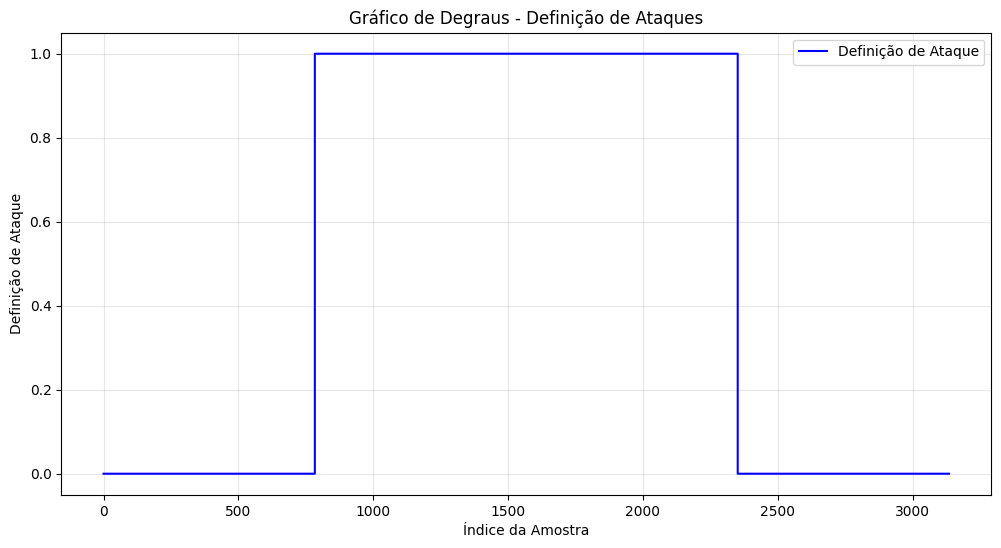

In [47]:
import pandas as pd

import matplotlib.pyplot as plt

# Escolher o arquivo CSV
arquivo_csv = 'data/03-11/attacks_estratificado_teste/MSSQL_estratificado.csv'  

# Carregar o arquivo CSV em um DataFrame
try:
    df_concatenado = pd.read_csv(arquivo_csv)
    print(f"Arquivo '{arquivo_csv}' carregado com sucesso!")
except Exception as e:
    print(f"Erro ao carregar o arquivo '{arquivo_csv}': {e}")

# Verificar se a coluna "definicao_ataque" está presente no DataFrame
if 'definicao_ataque' in df_concatenado.columns:
    # Plotar o gráfico de degraus
    plt.figure(figsize=(12, 6))
    plt.step(df_concatenado.index, df_concatenado['definicao_ataque'], where='mid', label='Definição de Ataque', color='blue')
    plt.title('Gráfico de Degraus - Definição de Ataques')
    plt.xlabel('Índice da Amostra')
    plt.ylabel('Definição de Ataque')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print('A coluna "definicao_ataque" não foi encontrada no DataFrame.')

# Análise de correlação (Random Forest)

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def analyze_csv_with_feature_importance(file_paths, label_column='definicao_ataque', output_file='importancia_colunas_rf.csv'):
    importance_data = []

    for file_path in file_paths:
        print(f"\n🔄 Processando arquivo: {file_path}")
        try:
            df = pd.read_csv(file_path, low_memory=False)
            df.dropna(axis=1, how='all', inplace=True)
            numeric_df = df.select_dtypes(include=[np.number])

            if label_column not in numeric_df.columns:
                print(f"  ⚠️ Coluna '{label_column}' não encontrada, pulando arquivo.")
                continue

            # Remover colunas indesejadas
            colunas_remover = [label_column, 'attack_label']
            colunas_existentes = [col for col in colunas_remover if col in numeric_df.columns]
            X = numeric_df.drop(columns=colunas_existentes, errors='ignore')
            y = numeric_df[label_column]

            X.replace([np.inf, -np.inf], np.nan, inplace=True)
            X.dropna(inplace=True)
            y = y.loc[X.index]

            if len(X) < 10 or len(set(y)) < 2:
                print("  ⚠️ Poucos dados ou classes únicas, pulando arquivo.")
                continue

            # Padronizar
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            # Treinar modelo
            model = RandomForestClassifier(n_estimators=30, random_state=42)
            model.fit(X_scaled, y)

            importances = model.feature_importances_
            total_importance = importances.sum()
            importances_percent = 100.0 * (importances / total_importance)

            row = {'arquivo': os.path.basename(file_path)}
            for col, imp in zip(X.columns, importances_percent):
                row[col] = imp

            importance_data.append(row)
            print(f"📊 Importâncias salvas para '{row['arquivo']}'")

        except Exception as e:
            print(f"❌ Erro ao processar {file_path}: {e}")

    if importance_data:
        df_output = pd.DataFrame(importance_data).fillna(0)
        df_output.to_csv(output_file, index=False)
        print(f"\n✅ Arquivo final salvo como: {output_file}")
    else:
        print("⚠️ Nenhum dado foi processado.")

        

def plot_top_features(file_path, top_n=20):
    # Carregar o CSV
    df_importancias = pd.read_csv(file_path)

    # Remover coluna 'arquivo' e somar importâncias por coluna
    somas = df_importancias.drop(columns=['arquivo']).sum().sort_values(ascending=False)

    # Selecionar as colunas com maior importância
    top_features = somas.head(top_n)

    # Plotar gráfico de barras
    plt.figure(figsize=(12, 6))
    top_features.plot(kind='bar', color='skyblue')
    plt.title(f'Top {top_n} Colunas por Importância Total (%)')
    plt.ylabel('Importância Total (%)')
    plt.xlabel('Colunas')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



In [69]:
csv_files = [
    'data/03-11/attacks_labeled/LDAP_processado.csv',
    'data/03-11/attacks_labeled/Mssql_processado.csv',
    'data/03-11/attacks_labeled/Syn_processado.csv',
    'data/03-11/attacks_labeled/UDP_processado.csv',
    'data/03-11/attacks_labeled/UDPLag_processado.csv'
]

analyze_csv_with_feature_importance(csv_files, output_file='data/03-11/correlacao_03-11.csv', label_column='definicao_ataque')





🔄 Processando arquivo: data/03-11/attacks_labeled/LDAP_processado.csv
📊 Importâncias salvas para 'LDAP_processado.csv'

🔄 Processando arquivo: data/03-11/attacks_labeled/Mssql_processado.csv
📊 Importâncias salvas para 'Mssql_processado.csv'

🔄 Processando arquivo: data/03-11/attacks_labeled/Syn_processado.csv
📊 Importâncias salvas para 'Syn_processado.csv'

🔄 Processando arquivo: data/03-11/attacks_labeled/UDP_processado.csv
📊 Importâncias salvas para 'UDP_processado.csv'

🔄 Processando arquivo: data/03-11/attacks_labeled/UDPLag_processado.csv
📊 Importâncias salvas para 'UDPLag_processado.csv'

✅ Arquivo final salvo como: data/03-11/correlacao_03-11.csv


In [70]:
csv_files = [
    'data/01-12/attacks_labeled/DrDos_DNS_processado.csv',
    'data/01-12/attacks_labeled/DrDos_LDAP_processado.csv',
    'data/01-12/attacks_labeled/DrDos_MSSQL_processado.csv',
    'data/01-12/attacks_labeled/DrDos_NetBIOS_processado.csv',
    'data/01-12/attacks_labeled/DrDos_NTP_processado.csv',
    'data/01-12/attacks_labeled/DrDos_SNMP_processado.csv',
    'data/01-12/attacks_labeled/DrDos_SSDP_processado.csv',
    'data/01-12/attacks_labeled/DrDos_UDP_processado.csv',
    'data/01-12/attacks_labeled/Syn_processado.csv',
    'data/01-12/attacks_labeled/UDPLag_processado.csv'    
]

analyze_csv_with_feature_importance(csv_files, output_file='data/01-12/correlacao_01-12.csv', label_column='definicao_ataque')


🔄 Processando arquivo: data/01-12/attacks_labeled/DrDos_DNS_processado.csv
📊 Importâncias salvas para 'DrDos_DNS_processado.csv'

🔄 Processando arquivo: data/01-12/attacks_labeled/DrDos_LDAP_processado.csv
📊 Importâncias salvas para 'DrDos_LDAP_processado.csv'

🔄 Processando arquivo: data/01-12/attacks_labeled/DrDos_MSSQL_processado.csv
📊 Importâncias salvas para 'DrDos_MSSQL_processado.csv'

🔄 Processando arquivo: data/01-12/attacks_labeled/DrDos_NetBIOS_processado.csv
📊 Importâncias salvas para 'DrDos_NetBIOS_processado.csv'

🔄 Processando arquivo: data/01-12/attacks_labeled/DrDos_NTP_processado.csv
📊 Importâncias salvas para 'DrDos_NTP_processado.csv'

🔄 Processando arquivo: data/01-12/attacks_labeled/DrDos_SNMP_processado.csv
📊 Importâncias salvas para 'DrDos_SNMP_processado.csv'

🔄 Processando arquivo: data/01-12/attacks_labeled/DrDos_SSDP_processado.csv
📊 Importâncias salvas para 'DrDos_SSDP_processado.csv'

🔄 Processando arquivo: data/01-12/attacks_labeled/DrDos_UDP_processado.

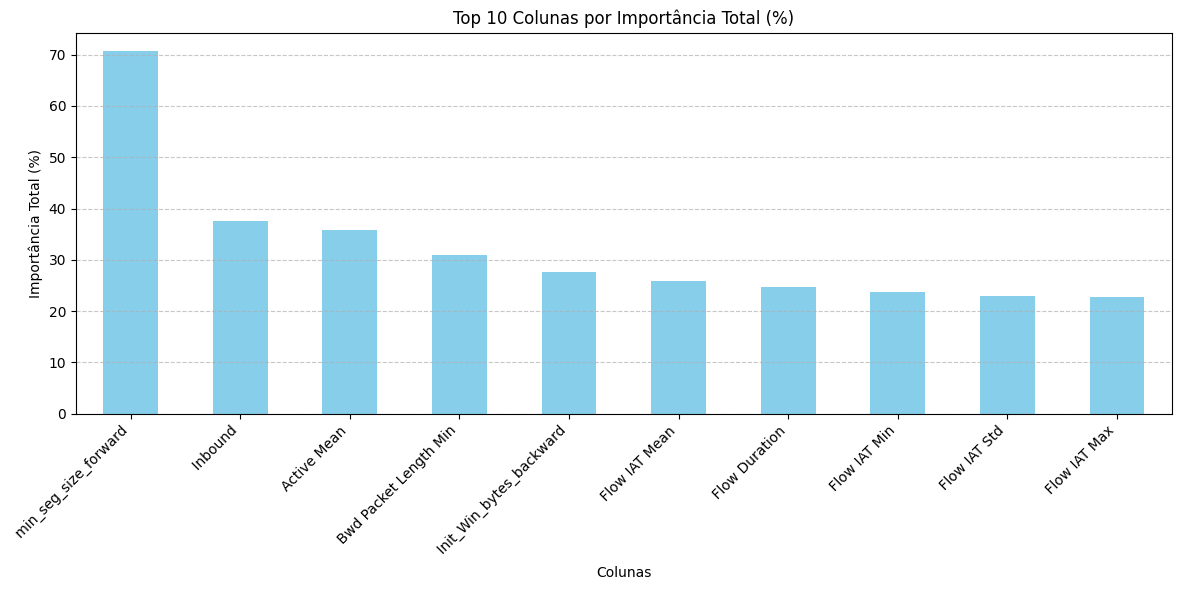

In [71]:
plot_top_features('data/01-12/correlacao_01-12.csv', top_n=10)

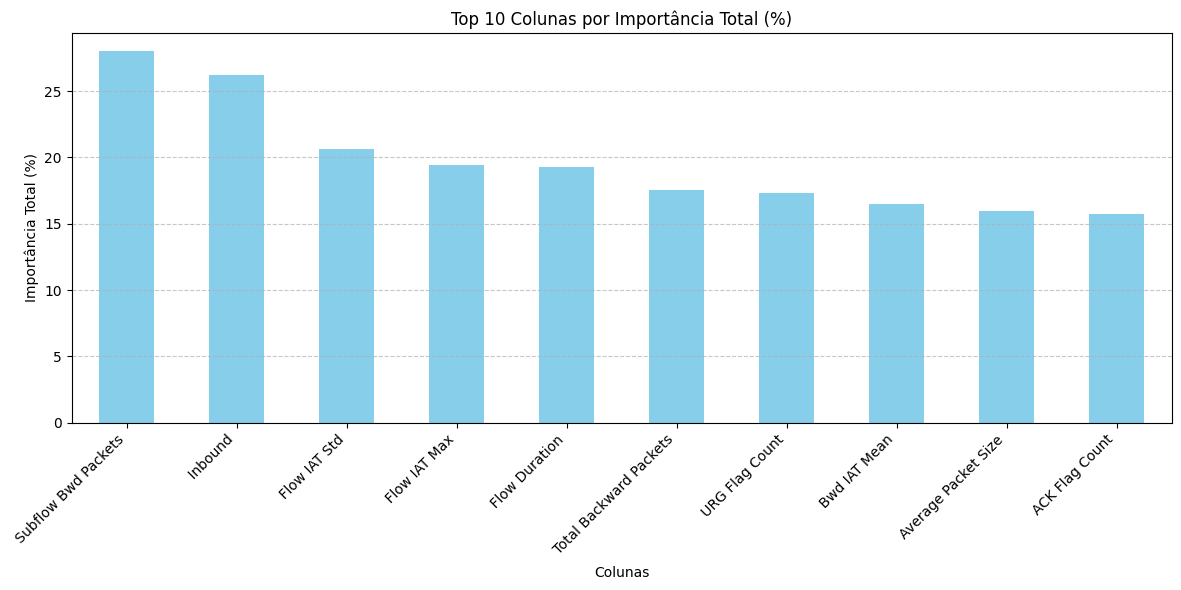

In [72]:
plot_top_features('data/03-11/correlacao_03-11.csv', top_n=10)

# Amostragem estratificada 

In [32]:
import pandas as pd

def concatenar_csvs_sequencialmente(arquivos_csv, chunk_size=10000):
    dfs = []

    for arquivo in arquivos_csv:
        try:
            print(f"📂 Processando arquivo: {arquivo}")
            for chunk in pd.read_csv(arquivo, chunksize=chunk_size):
                dfs.append(chunk)
        except Exception as e:
            print(f"Erro ao processar {arquivo}: {e}")

    if not dfs:
        print("Nenhum arquivo válido foi processado.")
        return None

    df_total = pd.concat(dfs, ignore_index=True)
    print("✅ Arquivos concatenados com sucesso.")
    return df_total


In [36]:
arquivos_csv = [ 
    'data/03-11/attacks_estratificado/NetBIOS_estratificado.csv',
    'data/03-11/attacks_estratificado/LDAP_estratificado.csv',
    'data/03-11/attacks_estratificado/MSSQL_estratificado.csv',
    'data/03-11/attacks_estratificado/UDP_estratificado.csv',
    'data/03-11/attacks_estratificado/UDPLag_estratificado.csv',
    'data/03-11/attacks_estratificado/Syn_estratificado.csv'
]

concatenar_csvs_sequencialmente(arquivos_csv, chunk_size=10000).to_csv('data/03-11/concatenado_03-11.csv', index=False)

📂 Processando arquivo: data/03-11/attacks_estratificado/NetBIOS_estratificado.csv
📂 Processando arquivo: data/03-11/attacks_estratificado/LDAP_estratificado.csv
📂 Processando arquivo: data/03-11/attacks_estratificado/MSSQL_estratificado.csv
📂 Processando arquivo: data/03-11/attacks_estratificado/UDP_estratificado.csv
📂 Processando arquivo: data/03-11/attacks_estratificado/UDPLag_estratificado.csv
📂 Processando arquivo: data/03-11/attacks_estratificado/Syn_estratificado.csv
✅ Arquivos concatenados com sucesso.


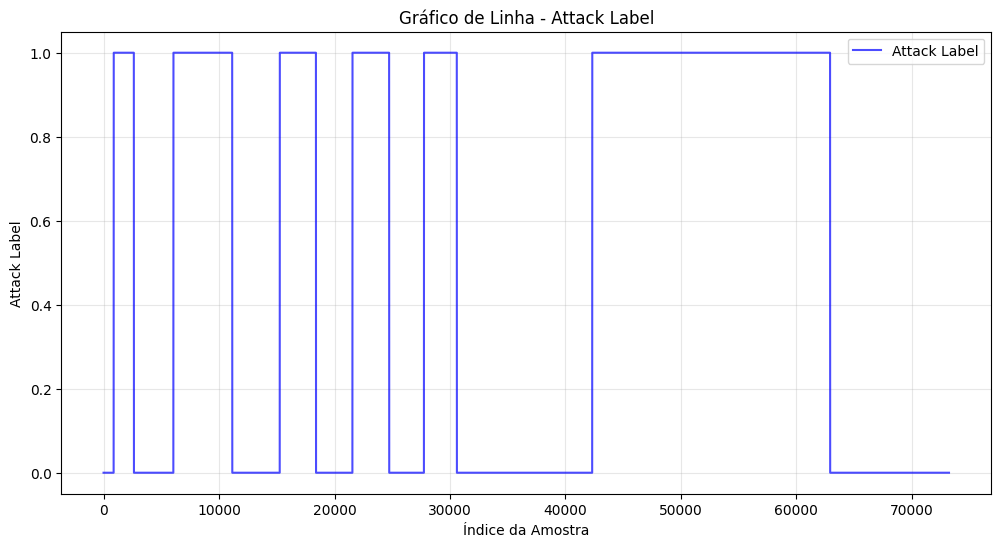

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o arquivo CSV
arquivo_csv = 'data/03-11/concatenado_03-11.csv'  # Substitua pelo caminho do arquivo desejado
df_concatenado = pd.read_csv(arquivo_csv)

# Verificar se a coluna "attack_label" está presente
if 'attack_label' in df_concatenado.columns:
    # Plotar gráfico de linha
    plt.figure(figsize=(12, 6))
    plt.plot(df_concatenado.index, df_concatenado['definicao_ataque'], label='Attack Label', color='blue', alpha=0.7)
    plt.title('Gráfico de Linha - Attack Label')
    plt.xlabel('Índice da Amostra')
    plt.ylabel('Attack Label')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print('A coluna "attack_label" não foi encontrada no DataFrame.')


In [ ]:
import

# LSTM

In [106]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

class SequenceDataset(Dataset):
    def __init__(self, path, sequence_length, column_to_remove=None):
        df = pd.read_csv(path, sep=',')

        if column_to_remove and column_to_remove in df.columns:
            df = df.drop(columns=[column_to_remove])

        # Separar features e labels
        features = df.iloc[:, :-1].values  # Assume que a última coluna é a label
        labels = df.iloc[:, -1].values

        # Normalizar os dados 
        # scaler = StandardScaler()
        # features = scaler.fit_transform(features)

        # Criar sequências
        sequences = []
        sequence_labels = []
        for i in range(len(features) - sequence_length + 1):
            seq = features[i:i+sequence_length]
            label = labels[i+sequence_length-1]  
            sequences.append(seq)
            sequence_labels.append(label)

        # Converter para tensores
        self.sequences = torch.tensor(sequences, dtype=torch.float32).view(-1, sequence_length, features.shape[1])
        self.labels = torch.tensor(sequence_labels, dtype=torch.long)
        # self.labels = torch.tensor(sequence_labels, dtype=torch.float32).unsqueeze(1) # Para binário / nn.BCEWithLogitsLoss()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return sequence, label
    
    
class LSTM_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Primeira camada LSTM
        self.lstm1 = nn.LSTM(input_size=input_size,
                             hidden_size=hidden_size//2,
                             num_layers=num_layers,
                             batch_first=True
                             
                             )
        
        # Segunda camada LSTM
        self.lstm2 = nn.LSTM(input_size=hidden_size//2,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,  
                             dropout=0.2  # Dropout entre as camadas LSTM                           
                            )
        
        self.lstm3 = nn.LSTM(input_size=hidden_size,
                             hidden_size=hidden_size//2,
                             num_layers=num_layers,
                             batch_first=True,
                             dropout=0.2  # Dropout entre as camadas LSTM
                             )
        
        # Camada fully-connected
        # self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()  # Para binário
        # self.fc = torch.nn.Linear(hidden_size, 1) # nn.BCEWithLogitsLoss() / nn.BCELoss()
        self.fc = torch.nn.Linear(hidden_size//2, output_size) # nn.CrossEntropyLoss()
        # Camada de ativação softmax
    
    def forward(self, x):
        out, _ = self.lstm1(x)  # Primeira camada LSTM
      
        out, _ = self.lstm2(out)  # Segunda camada LSTM
        
        out, _ = self.lstm3(out)  # Terceira camada LSTM
        
        out = torch.sigmoid(out)  # Aplicar sigmoid para obter probabilidades / Remover para nn.BCEWithLogitsLoss()
        # out = self.softmax(out)  # Aplicar softmax para obter probabilidades / Remover para nn.BCEWithLogitsLoss()
        out = self.fc(out[:, -1, :])  # Usar a última saída do LSTM como entrada para fc
        
        return out
    
    def save_model(self, filename):
        torch.save(self.state_dict(), filename)
        print(f"Modelo salvo em: {filename}")


# out = self.dropout(out)  # Aplicar dropout se necessário
# out = self.batch_norm(out)  # Aplicar batch normalization se necessário
# out = self.relu(out)  # Aplicar ReLU se necessário
# out = self.tanh(out)  # Aplicar Tanh se necessário
# out = self.sigmoid(out)  # Aplicar Sigmoid se necessário
# out = self.leaky_relu(out)  # Aplicar Leaky ReLU se necessário
# out = self.prelu(out)  # Aplicar PReLU se necessário
# out = self.elu(out)  # Aplicar ELU se necessário

Usando dispositivo: cuda


In [107]:
# Configurar os parâmetros da rede LSTM
input_size = 81         # Número de features no dataset / Tamanho do vetor de entrada por tempo
hidden_size = 256       # Tamanho do hidden state / Nº de unidades ocultas por célula
num_layers = 2         # Número de camadas LSTM / Nº de camadas LSTM empilhadas
output_size = 2        # Classes: normal (0), anomalia (1) 
batch_size = 128        # Batch size / 
num_epochs = 100         # Número de epochs
lr = 0.0011             # Learning rate
sequence_length = 1   # Tamanho da sequência de entrada para a LSTM
column_to_remove = ''  # Coluna a ser removida

# Criar os datasets
# train_dataset = SequenceDataset('data/cic_puro/treino_final_estratificado_random.csv', sequence_length, column_to_remove)
# test_dataset = SequenceDataset('data/cic_puro/teste_final_estratificado_random.csv', sequence_length, column_to_remove)

train_dataset = SequenceDataset('data/03-11/dataset_treino_lstm.csv', sequence_length, column_to_remove)
test_dataset = SequenceDataset('data/03-11/dataset_teste_lstm.csv', sequence_length, column_to_remove)


# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Formato dos loaders
for batch in train_loader:
    inputs, labels = batch
    print(f"Train Loader - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break

for batch in test_loader:
    inputs, labels = batch
    print(f"Test Loader - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break


Train Loader - Inputs shape: torch.Size([128, 1, 81]), Labels shape: torch.Size([128])
Test Loader - Inputs shape: torch.Size([128, 1, 81]), Labels shape: torch.Size([128])


In [108]:
# Criar o modelo
model = LSTM_model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
print(model)

# Testar a dimensão da entrada e saída do modelo
x, y = next(iter(train_loader))  
output = model(x)
print(f"Dimensão da entrada: {x.size()}")   # shape: [batch_size, sequence_length, input_size]
print(f"Dimensão da saída: {y.size()}")    # shape: [batch_size]
print(f"Dimensão da saída do modelo: {output.size()}") # shape: [batch_size, output_size]

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss: Para classificação multi-classe (softmax já incluído)
optimizer = optim.Adam(model.parameters(), lr=lr) # Adam: muito usado, bom para a maioria dos casos
# optimizer = optim.RMSprop(model.parameters(), lr=lr) # RMSprop: bom para dados sequenciais e LSTM


# Treinamento do modelo
best_loss = float('inf') # Inicializa a melhor perda como infinito
for epoch in range(num_epochs):
    # Treinamento
    model.train()
    for inputs, labels in train_loader:
        # inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 1, 2)
        outputs = model(inputs)   
        # labels = labels.view(-1, 1).float() # Ajustar o formato de labels para [batch_size, 1] / nn.BCEWithLogitsLoss()
        # loss = criterion(outputs.squeeze(1), labels.float()) # nn.BCEWithLogitsLoss()
        loss = criterion(outputs.squeeze(), labels) #  nn.BCELoss()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validação
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 1, 2)
            outputs = model(inputs)
            # labels = labels.view(-1, 1).float() # Ajustar o formato de labels para [batch_size, 1] / nn.BCEWithLogitsLoss()
            val_loss += criterion(outputs.squeeze(), labels).item()
    
    avg_val_loss = val_loss / len(test_loader)

    # Calcular a acurácia
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 1, 2)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
   
    acc = accuracy_score(y_true, y_pred)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {acc:.4f}')
    
    # Salvar o melhor modelo
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), f'models/LSTM/best_lstm_model_{acc:.2f}.pth')
        print('Melhor modelo salvo!')

LSTM_model(
  (lstm1): LSTM(81, 128, num_layers=2, batch_first=True)
  (lstm2): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (lstm3): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.2)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
Dimensão da entrada: torch.Size([128, 1, 81])
Dimensão da saída: torch.Size([128])
Dimensão da saída do modelo: torch.Size([128, 2])
Epoch [1/100], Loss: 0.6033, Val Loss: 0.5809, Accuracy: 0.8152
Melhor modelo salvo!
Epoch [2/100], Loss: 0.5747, Val Loss: 0.4243, Accuracy: 0.8523
Melhor modelo salvo!
Epoch [3/100], Loss: 0.4342, Val Loss: 0.3864, Accuracy: 0.8637
Melhor modelo salvo!
Epoch [4/100], Loss: 0.2126, Val Loss: 0.3727, Accuracy: 0.8699
Melhor modelo salvo!
Epoch [5/100], Loss: 0.4699, Val Loss: 0.3668, Accuracy: 0.8653
Melhor modelo salvo!
Epoch [6/100], Loss: 0.2376, Val Loss: 0.3770, Accuracy: 0.8653
Epoch [7/100], Loss: 0.2830, Val Loss: 0.3673, Accuracy: 0.8735
Epoch [8/100], Loss

# CNN

In [19]:
# 📦 CÉLULA 1 – IMPORTAÇÕES E CONFIGURAÇÕES
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo em uso: {device}")


Dispositivo em uso: cuda


In [20]:
# 📄 CÉLULA 2 – DATASET COM REMOÇÃO DE COLUNA E DIVISÃO EM SEQUÊNCIAS
class SequenceDataset(Dataset):
    def __init__(self, path, sequence_length, column_to_remove=None):
        df = pd.read_csv(path)

        # Remover coluna opcional (como timestamp ou id)
        if column_to_remove and column_to_remove in df.columns:
            df = df.drop(columns=[column_to_remove])

        # Separar features e labels
        data = df.drop(columns=['label']).values
        labels = df['label'].values

        self.sequences = []
        self.labels = []

        for i in range(len(data) - sequence_length + 1):
            self.sequences.append(data[i:i+sequence_length])
            self.labels.append(labels[i+sequence_length-1])

        # Formato final: (batch, channels=1, time_steps)
        self.sequences = torch.tensor(self.sequences, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


In [21]:
# 🧠 CÉLULA 3 – DEFINIÇÃO DO MODELO CNN 1D
class CNN1DNet(nn.Module):
    def __init__(self, input_length, output_size=2):
        super(CNN1DNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Flatten(),
            nn.Linear((input_length // 4) * 64, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
sequence_length = 20
input_size = 9     
output_size = 2
batch_size = 32
num_epochs = 20
lr = 0.001
column_to_remove = 'attack_name'

train_dataset = SequenceDataset('data/cic_puro_enhanced/01-12-train.csv', sequence_length, column_to_remove)
test_dataset  = SequenceDataset('data/cic_puro_enhanced/03-11-test.csv', sequence_length, column_to_remove)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
model = CNN1DNet(input_length=sequence_length, output_size=output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 🔍 Validação
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predicted = torch.argmax(outputs, dim=1).cpu()
            y_pred.extend(predicted.numpy())
            y_true.extend(y_batch.numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"Época {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

    if acc > best_accuracy:
        best_accuracy = acc
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        print("✅ Novo melhor modelo salvo com accuracy:", best_accuracy)


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [32, 1, 20, 9]

# LSTM-CNN-SVM

In [ ]:
class CNN_LSTM_model(nn.Module):
    def __init__(self, input_size=9, hidden_size=64, num_layers=2, output_size=2):
        super(CNN_LSTM_model, self).__init__()
        
        # Camada CNN para extrair características locais
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Camada LSTM
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        
        # Camada全连接 após a LSTM
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # A CNN espera (batch_size, channels, sequence_length), então precisamos transpor
        x = x.permute(0, 2, 1)  # [batch_size, seq_length, input_size] -> [batch_size, input_size, seq_length]
        
        out = self.cnn(x)
        out = out.permute(0, 2, 1)  # Volta para [batch_size, sequence_length, channels]
        
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])  # Pega o último timestep
        return out
